**Notebook Reset**

In [1]:
# Notebook-Reset: Kernel und Imports zurücksetzen
%reset -f  # Löscht alle Variablen
import sys
if 'functions' in sys.modules:
    del sys.modules['functions']  # Import-Cache für eigene Module löschen

Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  löscht, please run `%reset?` for details
Don't know how to reset  alle, please run `%reset?` for details
Don't know how to reset  variablen, please run `%reset?` for details


**Imports**

In [2]:
# Imports und Funktions-Imports
# Standard- und externe Bibliotheken
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

# Eigene Funktions-Module für Daten, Berechnung und Steuerung
from functions.retro_data.weather_data import get_weather
from functions.retro_data.spotprice_data import get_spotprice
from functions.retro_data.consumption_data import get_demand
from functions.calculations.calculations import calculate_energy
from functions.calculations.kpis import calculate_kpis
from functions.deciding_functions.optimized import optimize_energy_flow
from functions.deciding_functions.reinforcementlearning.reinforcementlearning_train import reinforcement_learning_train
from functions.deciding_functions.reinforcementlearning.reinforcementlearning_test import reinforcement_learning_test
from functions.deciding_functions.rulebased import rule_based_energy_flow
from functions.results.results import get_results

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


**Definition des Green Energy Ecosystems**

In [3]:
# Systemparameter und Annahmen
# Hier werden alle relevanten Systemparameter für PV, Wind, Batterie, Verbraucher etc. gesetzt.
# Werte können für Szenarien einfach angepasst werden.

# Photovoltaik
solar_peak_power = 38  # Spitzenleistung Gesamtsystem PV [MW]
num_modules = 114980 #Anzahl Solarmodule
area_per_module = 1.57458  # Fläche pro Modul [m²] (Annahme Heckert Solar NeMo® 2.0 330 Wp)
module_efficiency = 0.196  # Wirkungsgrad der Solarmodule (Annahme Heckert Solar NeMo® 2.0 330 Wp)
tilt_angle = 45  # Neigungswinkel der Solarpanels [°] (Annahme)
latitude=51.751111 # Breitengrad
longitude=4.208611 # Längengrad
azimuth=180 # Azimut [°]
albedo=0.2 # Albedo

# Windkraft 
wind_peak_power = 22   # Spitzenleistung Gesamtsystem Windkraft [MW]
r = 60 # Rotor Radius [m]
h = 90 # Höhe Windrad [m]
turbine_efficiency = 0.5  # Wirkungsgrad der Windkraftanlagen (Annahme)
cut_in = 2.5  # Einschaltgeschwindigkeit [m/s]
cut_out = 28  # Abschaltgeschwindigkeit [m/s]
num_turbines = 6 # Anzahl Windkraftanlagen

# Batteriespeicher
battery_capacity = 12  # [MWh]
soc = 0.5  # State of Charge (SOC) initial [0-1]
initial_battery = soc * battery_capacity  # [MWh]
charging_rate = 10  # Lade-/Entladerate [MW]
discharging_rate = 10

# Verbraucher
yearly_demand = 2.7  #  Verbrauch eines Haushalts/Jahr [MWh] (Annahme)
num_houses = 39000  # Anzahl Haushalte

# Strompreis
export_factor = 0.25   # Anteil vom Spotpreis für Einspeisung
price_low_quant  = 0.30   # Regelbasiert: Niedrigpreis-Schwelle

# Parameter für Sliding Window
test_month = 5  # Startmonat für das Sliding Window (1 bis 5) (5)
test_timeframe = 3  # Datensatz kürzen [Tage] (7)
forecast_horizon = 1    # Länge des Fensters [Tage] (2)
stepsize = 1    # Schrittweite [Stunden] (1)

# RL Parameter
split = 80/20 # Train/Test Split
total_timesteps = 500  # Anzahl der Schritte für das Training des RL-Agenten

**Vorbereiten der Datensätze**

In [4]:
# Daten laden und vorbereiten
# Wetter-, Preis- und Verbrauchsdaten werden geladen und zu einem DataFrame zusammengeführt.

# Daten laden
# (liefert DataFrames mit Zeitstempel)
df_weather = get_weather()
df_spot = get_spotprice()
df_demand = get_demand(num_houses, yearly_demand)

# Datensätze mergen (alle Zeitreihen auf gemeinsamen Zeitstempel bringen)
df_merged = df_weather.merge(
    df_spot[['datetime', 'spotprice']],
    on='datetime', how='left'
).merge(
    df_demand[['datetime', 'energy_demand']],
    on='datetime', how='left'
)

# Split: Erstes Jahr = Training, Rest = Test
df_merged["datetime"] = pd.to_datetime(df_merged["datetime"])
train_end = df_merged["datetime"].min() + pd.DateOffset(years=1)
df_train = df_merged[df_merged["datetime"] < train_end].reset_index(drop=True)
df_test = df_merged[df_merged["datetime"] >= train_end].reset_index(drop=True)

# Optional: Daten anzeigen
# display(df_weather.head(5)), display(df_spot.head(5)), display(df_demand.head(5))
# display(df_train.head(5)), display(df_test.head(5))
# display(df_merged.head(5))

In [5]:
# Datensätze zuschneiden (Sliding Window)
# Trainings- und Testdaten werden auf die gewünschten Zeiträume gekürzt.

# Testdatensatz: Startet im gewünschten Monat, Länge = test_timeframe Tage
first_of_month = df_test[
    (df_test["datetime"].dt.month == test_month)
]["datetime"].min()

start = first_of_month
end = start + pd.Timedelta(days=test_timeframe)

df_test = df_test[(df_test["datetime"] >= start) & (df_test["datetime"] < end)].reset_index(drop=True)

# Trainingsdatensatz: Startet im gleichen Monat, Länge = test_timeframe*split Tage
first_of_month = df_train[
    (df_train["datetime"].dt.month == test_month)
]["datetime"].min()

start = first_of_month
end = start + pd.Timedelta(days=test_timeframe*split)

df_train = df_train[(df_train["datetime"] >= start) & (df_train["datetime"] < end)].reset_index(drop=True)

# Optional: Daten anzeigen
# display(df_train.head()), display(df_test.head())
# print(len(df_train), len(df_test))

**Ausführen der Berechnungsfunktion**

In [6]:
# Energie- und Bedarfsberechnung für Trainings- und Testdaten
# Berechnet PV-/Wind-Ertrag und merged alle relevanten Spalten.

df_energy_test = calculate_energy(
    df_test, 
    solar_peak_power, num_modules, area_per_module, module_efficiency, tilt_angle, latitude, longitude, azimuth, albedo, 
    wind_peak_power, r, h, turbine_efficiency, cut_in, cut_out, num_turbines
)
df_test = df_energy_test.merge(
    df_spot[['datetime', 'spotprice']],
    on='datetime', how='left'
 ).merge(
    df_demand[['datetime', 'energy_demand']],
    on='datetime', how='left'
 ).reset_index(drop=True)

df_energy_train = calculate_energy(
    df_train, 
    solar_peak_power, num_modules, area_per_module, module_efficiency, tilt_angle, latitude, longitude, azimuth, albedo, 
    wind_peak_power, r, h, turbine_efficiency, cut_in, cut_out, num_turbines
)
df_train = df_energy_train.merge(
    df_spot[['datetime', 'spotprice']],
    on='datetime', how='left'
 ).merge(
    df_demand[['datetime', 'energy_demand']],
    on='datetime', how='left'
 ).reset_index(drop=True)

# Optional: Daten anzeigen
# display(df_train.head()), display(df_test.head())

**Plot der Energiedaten und relevanten Wetterdaten**

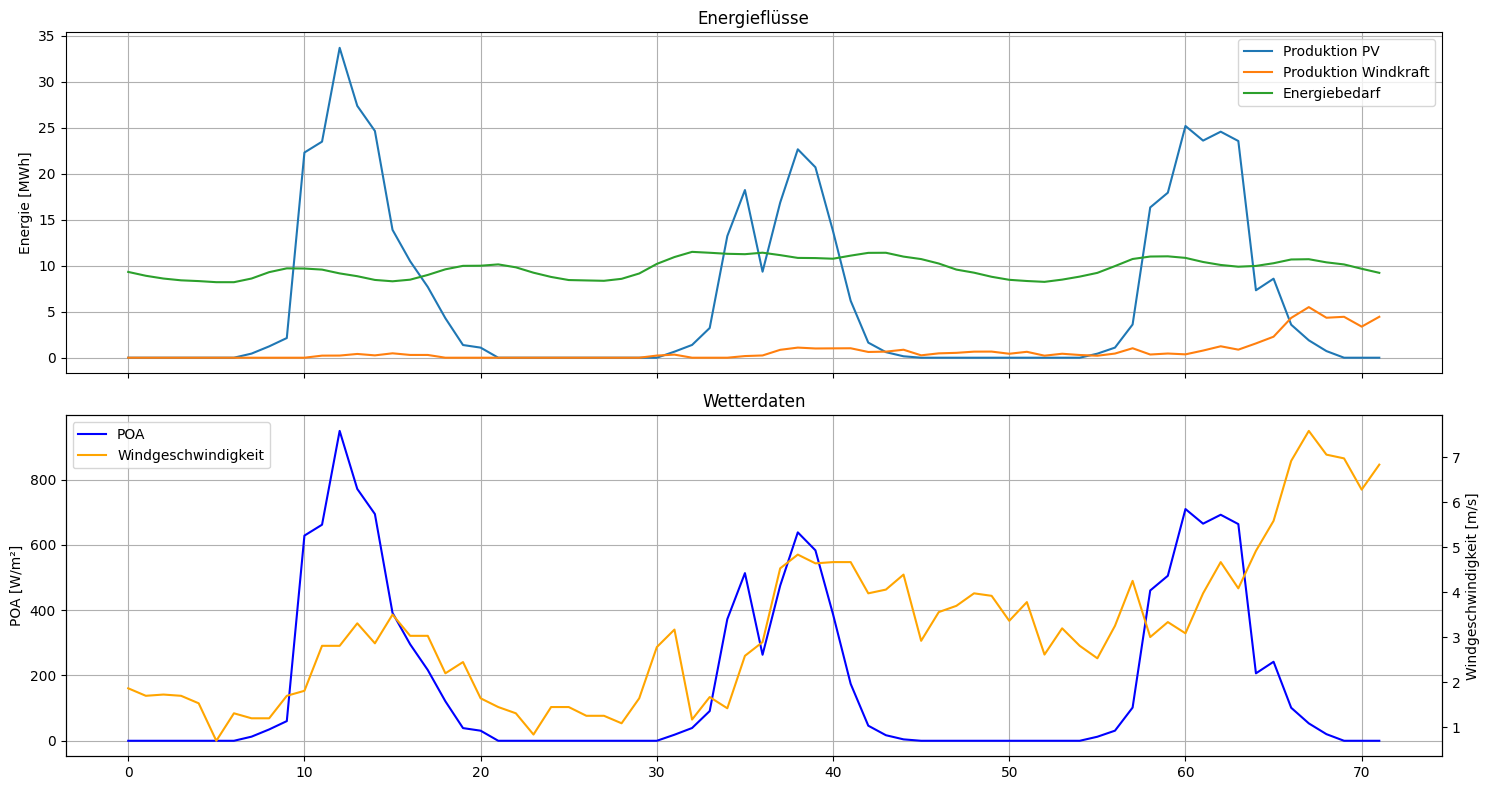

In [7]:
# Plot: Energie- und Wetterdaten (Testdaten)
# Visualisiert PV-/Wind-Erzeugung, Bedarf und Wetterdaten für den Testzeitraum.

df_plot = df_test.copy()

# Figure mit zwei Subplots (Energieflüsse und Wetter)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Energieflüsse
ax1.plot(df_plot.index, df_plot["solar_energy_production"], label="Produktion PV")
ax1.plot(df_plot.index, df_plot["wind_energy_production"], label="Produktion Windkraft")
ax1.plot(df_plot.index, df_plot["energy_demand"], label="Energiebedarf")
ax1.set_ylabel("Energie [MWh]")
ax1.set_title("Energieflüsse")
ax1.legend()
ax1.grid(True)

# Wetterdaten (POA und Windgeschwindigkeit)
ax2a = ax2  # linke Achse
ax2b = ax2a.twinx()  # rechte Achse

line1, = ax2a.plot(df_plot.index, df_plot["poa_irradiance"], color="blue", label="POA")
line2, = ax2b.plot(df_plot.index, df_plot["windspeed"] / 3.6, color="orange", label="Windgeschwindigkeit")

ax2a.set_ylabel("POA [W/m²]")
ax2a.tick_params(axis='y')
ax2b.set_ylabel("Windgeschwindigkeit [m/s]")
ax2b.tick_params(axis='y')
ax2a.set_title("Wetterdaten")

# Gemeinsame Legende unten
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax2.grid(True)
ax2a.legend(lines, labels, loc="upper left")

plt.xlabel("Zeit")
plt.tight_layout()
plt.show()

**Ausführen der Entscheidungs-Funktionen**

In [8]:
# Regelbasierte Steuerung (Testdaten)
# Einfache Heuristik für Batterie- und Netzmanagement.

result_df_rule = rule_based_energy_flow(
    df_test, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, price_low_quant
    )

result_kpis_rule = calculate_kpis(result_df_rule, export_factor)

In [9]:
# Mathematische Optimierung (Testdaten)
# Optimiert die Energieflüsse für das Testfenster mit Extremwertproblem.

result_df_opt = optimize_energy_flow(
    df_test, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, 
    forecast_horizon, stepsize
    )

result_kpis_opt = calculate_kpis(result_df_opt, export_factor)

In [10]:
# Reinforcement Learning: Training
# Trainiert das RL-Modell auf den Trainingsdaten (Sliding Window, SOC-Übergabe).

result_df_rl = reinforcement_learning_train(
    df_train,
    battery_capacity,
    initial_battery,
    charging_rate,
    discharging_rate,
    export_factor,
    forecast_horizon,
    stepsize,
    total_timesteps
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 24        |
|    ep_rew_mean      | -6.72e+03 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 4         |
|    fps              | 1627      |
|    time_elapsed     | 0         |
|    total_timesteps  | 96        |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 24        |
|    ep_rew_mean      | -6.81e+03 |
|    exploration_rate | 0.05      |
| time/               |           |
|    episodes         | 8         |
|    fps              | 372       |
|    time_elapsed     | 0         |
|    total_timesteps  | 192       |
| train/              |           |
|    learning_rate    | 0.0001    |
|

KeyboardInterrupt: 

In [ ]:
# Reinforcement Learning: Test mit gespeichertem Modell
# Lädt das trainierte Modell und testet es auf den Testdaten (Sliding Window, SOC-Übergabe).

from stable_baselines3 import DQN
from functions.deciding_functions.reinforcementlearning.reinforcementlearning_train import EMSenv

# Modell laden
model = DQN.load("model/rl_model_trained.zip")

# Testfunktion ausführen (Parameter wie beim Training)
env_kwargs = {
    'battery_capacity': battery_capacity,
    'charging_rate': charging_rate,
    'discharge_rate': discharging_rate,
    'export_price_factor': export_factor,
}

result_df_rl = reinforcement_learning_test(
    model,
    df_test,
    EMSenv,
    env_kwargs,
    forecast_horizon,
    stepsize,
    initial_battery
)

result_kpis_rl = calculate_kpis(result_df_rl, export_factor)

Regelbasiert:
Netto Stromkosten: 33662.38 €
Netzstromkosten: 31765.33 €
Einspeisevergütung: -1897.05 €
Export-gewichteter Preis (rule): -38.87 €/MWh
Netzbezug: 378.23 MWh
Einspeisung: 195.23 MWh
Batterieladung: 38.42 MWh
Batterieentladung: 44.42 MWh
----------------------
Optimiert:
Netto Stromkosten: 27044.24 €
Netzstromkosten: 24159.48 €
Einspeisevergütung: -2884.76 €
Export-gewichteter Preis (opt):  -30.39 €/MWh
Netzbezug: 557.95 MWh
Einspeisung: 379.72 MWh
Batterieladung: 85.36 MWh
Batterieentladung: 91.36 MWh
----------------------
Reinforcement Learning:
Netto Stromkosten: 34688.18 €
Netzstromkosten: 32792.65 €
Einspeisevergütung: -1895.53 €
Export-gewichteter Preis (RL):  -40.09 €/MWh
Netzbezug: 377.65 MWh
Einspeisung: 189.13 MWh
Batterieladung: 40.00 MWh
Batterieentladung: 40.48 MWh
----------------------


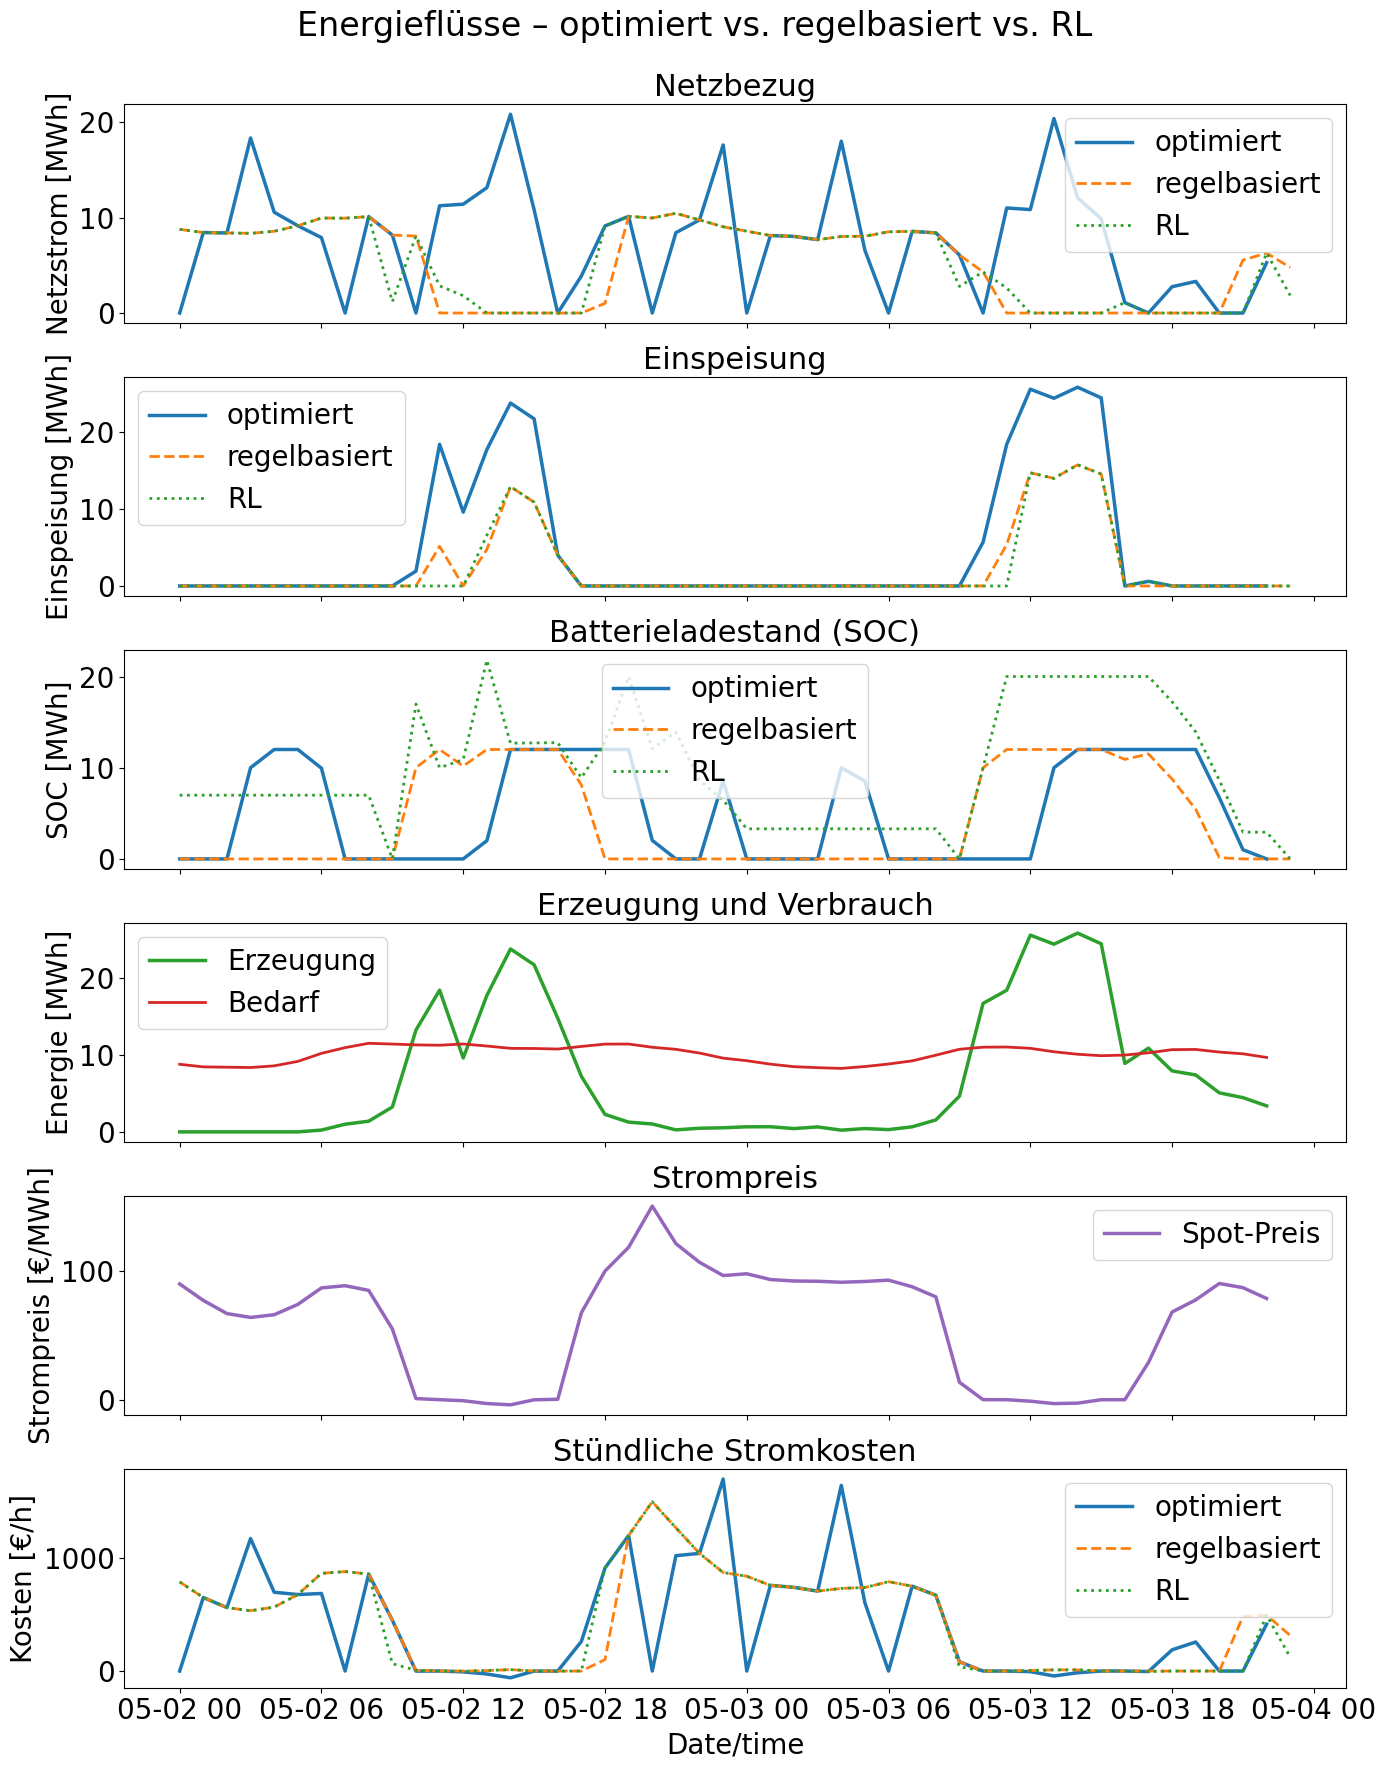

In [ ]:
# Ergebnisfunktion: KPIs und Vergleich
# Gibt die wichtigsten Kennzahlen und Vergleiche für alle Ansätze aus.

get_results(result_df_rule, result_df_opt, result_df_rl, result_kpis_rule, result_kpis_opt, result_kpis_rl, export_factor)